In [292]:
from collections import Counter

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_validate

movie_df = pd.read_csv(r'data/data_regression.csv')
movie_df = movie_df.set_index('imdb_id')

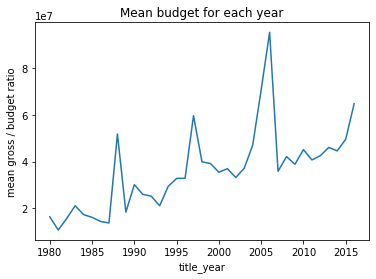

In [294]:
grouped_by_year = movie_df.groupby("title_year").budget.mean()
sns.lineplot(grouped_by_year.index, grouped_by_year)
plt.ylabel("mean gross / budget ratio")
plt.title("Mean budget for each year with missing values")
plt.show()

Even if the mean of budgets of each year is not zero, it can happens that the budget of some movies is zero (this means that the value was missed and we replaced it with zero)

In [295]:
zero_budget = (movie_df.budget==0).values
num_zero_budget = zero_budget.sum()
print(f"Number of missed budget values = {num_zero_budget}")

Number of missed budget values = 100


For each movie we have a rank of its director and its cast. These elements are the ones which influence most the movie's budget. Another feature which influence the cost of a movie is the genre. We will rank every movie considering cast/director and its genre

**cast/director**

In [296]:
# rank for the cast considering its 3 actors rank
fill_budget_df = movie_df[['actor1_rank','actor2_rank','actor3_rank']]

In [297]:
# the protagonist has a bigger weight than others: 50% first actor, 30% second actor, 20% third actor
fill_budget_df['rank_cast'] = fill_budget_df.actor1_rank * 0.5 + fill_budget_df.actor2_rank * 0.30 + fill_budget_df.actor2_rank * 0.2
fill_budget_df.head()

,actor1_rank,actor2_rank,actor3_rank,rank_cast
imdb_id,,,,
tt0035423,6,3,4,4.5
tt0080339,2,3,4,2.5
tt0080453,3,3,3,3.0
tt0080455,3,3,4,3.0
tt0080487,7,3,5,5.0


In [298]:
fill_budget_df = fill_budget_df.drop(columns= ['actor1_rank','actor2_rank','actor3_rank'])
fill_budget_df['director_rank'] = movie_df.director_rank
fill_budget_df.head()

,rank_cast,director_rank
imdb_id,,
tt0035423,4.5,0
tt0080339,2.5,1
tt0080453,3.0,0
tt0080455,3.0,0
tt0080487,5.0,0


**genre**

Some genres requires a bigger investment. We found some articles which proves that (see Report). In particular, the most expensive are
- Action_Adventure
- Sci-Fi_Fantasy
- History_War

Average 65 milion

Then there is
- Animation

Average 60 milion

Others have a mean of 20 milion.

Then we can assign to each movie a rank based on genre average cost:

In [299]:
movie_genres = movie_df[[
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War','Others']]

movie_genres.head()

,Biography,Comedy,Crime,Drama,Romance,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others
imdb_id,,,,,,,,,,,
tt0035423,0,1,0,0,1,0,1,0,0,0,0
tt0080339,0,1,0,0,0,0,0,0,0,0,0
tt0080453,0,0,0,1,1,0,0,0,1,0,0
tt0080455,0,1,1,0,0,0,0,0,1,0,1
tt0080487,0,1,0,0,0,0,0,0,0,0,1


In [300]:
genre_rank = []

for i in range(len(movie_genres)): #for each movie
    index = movie_genres.index[i]
    rowData = movie_genres.loc[ index , : ] # all genres of one movie
    
    if rowData.Action_Adventure==1 or rowData['Sci-Fi_Fantasy']==1 or rowData.History_War==1 :
        genre_rank.append(1)
    elif rowData.Family_Animation==1 :
        genre_rank.append(round(float(60/65),2))
    else :
        genre_rank.append(round(float(60/65),2))


In [301]:
fill_budget_df['genre_rank'] = genre_rank
fill_budget_df = fill_budget_df.sort_values('director_rank', ascending=False) #sort values

# scale 0-1 also for rank_cast and director_rank
fill_budget_df.rank_cast = fill_budget_df.rank_cast/fill_budget_df.rank_cast.max()
fill_budget_df.director_rank = [round(float(x),2) for x in fill_budget_df.director_rank]
fill_budget_df.director_rank = fill_budget_df.director_rank/fill_budget_df.director_rank.max()


Warning!!!! remember to comment that this is a ranking of importance. it does not mean that the costs are 0.3 0.3 0.3

We suppose each is equally important:

In [302]:
fill_budget_df['rank_for_budget'] = fill_budget_df.mean(axis=1)
fill_budget_df.head()

,rank_cast,director_rank,genre_rank,rank_for_budget
imdb_id,,,,
tt1659337,0.40,1.0,0.92,0.773333
tt2582802,0.55,0.9,0.92,0.790000
tt1431045,0.45,0.8,1.00,0.750000
tt0470752,0.20,0.8,1.00,0.666667
tt2084970,0.40,0.7,1.00,0.700000


In [303]:
fill_budget_df = fill_budget_df.drop(columns= ['rank_cast','director_rank','genre_rank'])
fill_budget_df['budget'] = movie_df.budget
fill_budget_df = fill_budget_df.sort_values('rank_for_budget', ascending=False) #sort values
fill_budget_df.head(20)

,rank_for_budget,budget
imdb_id,,
tt2582802,0.790000,3300000.0
tt0372784,0.783333,150000000.0
tt0468569,0.783333,185000000.0
tt1659337,0.773333,13000000.0
tt0482571,0.766667,40000000.0
tt1375666,0.766667,160000000.0
tt1431045,0.750000,58000000.0
tt1345836,0.750000,250000000.0
tt0816692,0.750000,165000000.0


Now each film has a rank of features which influence the budget. Keep all of them would be too complicate, then we identify a rank of 20 values.


In [304]:
massimo = fill_budget_df.rank_for_budget.max()
fill_budget_df['rank_for_budget_integer'] = [int(x) for x in fill_budget_df.rank_for_budget/massimo*2*10]
fill_budget_df.head(10)

,rank_for_budget,budget,rank_for_budget_integer
imdb_id,,,
tt2582802,0.790000,3300000.0,20
tt0372784,0.783333,150000000.0,19
tt0468569,0.783333,185000000.0,19
tt1659337,0.773333,13000000.0,19
tt0482571,0.766667,40000000.0,19
tt1375666,0.766667,160000000.0,19
tt1431045,0.750000,58000000.0,18
tt1345836,0.750000,250000000.0,18
tt0816692,0.750000,165000000.0,18


In [330]:
# mean of each rank of budget, ignoring movies with missing budget (which would bias the mean)

# ignore zero budget movies
movies_with_budget_df = fill_budget_df.drop(fill_budget_df[fill_budget_df.budget==0].index)
movies_with_budget_df = movies_with_budget_df.drop(columns='rank_for_budget')
data = movies_with_budget_df.groupby(movies_with_budget_df.rank_for_budget_integer)
data = data.mean()
data.head(20)

,budget
rank_for_budget_integer,
7,3.917000e+05
8,1.014151e+08
9,1.577493e+07
10,3.245254e+07
11,3.999370e+07
12,7.332693e+07
13,5.817836e+07
14,7.363850e+07
15,8.998944e+07


Now for each rank (no movies under rank = 7) we have the mean of its movies. We can assign this value of budget to movies with missing budget

In [309]:
movies_missing_budget_df = fill_budget_df.drop(fill_budget_df[fill_budget_df.budget>0].index)
movies_missing_budget_df = movies_missing_budget_df.drop(columns='rank_for_budget')
movies_missing_budget_df.head()

,budget,rank_for_budget_integer
imdb_id,,
tt1266029,0.0,13
tt1465522,0.0,13
tt1172570,0.0,13
tt0455499,0.0,13
tt1175709,0.0,12


In [308]:
print(f"We check that they are actually {len(movies_missing_budget_df)} movies")

We check that they are actually 100 movies


In [353]:
# fill values
for i in range(len(movies_missing_budget_df)):
    index = movies_missing_budget_df.index[i]
    rowData = movies_missing_budget_df.loc[ index , : ] # all genres of one movie
    rank_movie = int(rowData.rank_for_budget_integer)
    
    budget_movie =  data.loc[ rank_movie , : ].budget

    movie_df.update(
        movie_df.loc[movie_df.index == index, 'budget'].replace(0.0, budget_movie, regex=True)
    )

In [354]:
# we should have filled all zero budget values. check:
zero_budget = (movie_df.budget==0).values
num_zero_budget = zero_budget.sum()
print(f"Number of missed budget values = {num_zero_budget}")

Number of missed budget values = 0
